In [143]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import glob
from tqdm import tqdm
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, Input, models, layers, metrics
import shutil
import cv2
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.image as mping

In [144]:
# !pip install tqdm

In [145]:
class CFG:
    img_size = 516
    channels = 3
    batch_size = 5

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # python random
    rnd.seed(seed)
    # numpy random
    np_rnd.seed(seed)
    # RAPIDS random
    try:
        cupy.random.seed(seed)
    except:
        pass
    # tf random
    try:
        tf_rnd.set_seed(seed)
    except:
        pass
    # pytorch random
    try:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    except:
        pass

def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def findIdx(data_x, col_names):
    return [int(i) for i, j in enumerate(data_x) if j in col_names]

def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

## 데이터 프레임 만들어 놓기

In [146]:
df = pd.DataFrame()
df["file_path"] = glob.glob("./images/*")
df["file_name"] = df["file_path"].apply(lambda x: x.split("\\")[-1])
df["img_idx"] = df["file_name"].apply(lambda x: x.split("_")[-1].split(".")[0]).astype("int64")
df["type"] = df["file_name"].apply(lambda x: x.split("_")[0])
df["ext"] = df["file_name"].apply(lambda x: x.split(".")[-1])

In [147]:
df

,file_path,file_name,img_idx,type,ext
0,./images\Test_0.jpg,Test_0.jpg,0,Test,jpg
1,./images\Test_1.jpg,Test_1.jpg,1,Test,jpg
2,./images\Test_10.jpg,Test_10.jpg,10,Test,jpg
3,./images\Test_100.jpg,Test_100.jpg,100,Test,jpg
4,./images\Test_1000.jpg,Test_1000.jpg,1000,Test,jpg
...,...,...,...,...,...
3637,./images\Train_995.jpg,Train_995.jpg,995,Train,jpg
3638,./images\Train_996.jpg,Train_996.jpg,996,Train,jpg
3639,./images\Train_997.jpg,Train_997.jpg,997,Train,jpg
3640,./images\Train_998.jpg,Train_998.jpg,998,Train,jpg


In [148]:
df = pd.DataFrame()
df

""


In [149]:
df['file_path'] = glob.glob('./images/*')
df["file_name"] = df["file_path"].str.split('\\').str[1]
df["img_idx"] = df["file_name"].str.split('_').str[-1].str.split('.').str[0].astype(int)
df["type"] = df["file_name"].str.split('_').str[0]
df["ext"] = df["file_name"].str.split('.').str[-1]
df

,file_path,file_name,img_idx,type,ext
0,./images\Test_0.jpg,Test_0.jpg,0,Test,jpg
1,./images\Test_1.jpg,Test_1.jpg,1,Test,jpg
2,./images\Test_10.jpg,Test_10.jpg,10,Test,jpg
3,./images\Test_100.jpg,Test_100.jpg,100,Test,jpg
4,./images\Test_1000.jpg,Test_1000.jpg,1000,Test,jpg
...,...,...,...,...,...
3637,./images\Train_995.jpg,Train_995.jpg,995,Train,jpg
3638,./images\Train_996.jpg,Train_996.jpg,996,Train,jpg
3639,./images\Train_997.jpg,Train_997.jpg,997,Train,jpg
3640,./images\Train_998.jpg,Train_998.jpg,998,Train,jpg


In [150]:
df["ext"] = df["file_name"].str.split('.').str[-1]
df

,file_path,file_name,img_idx,type,ext
0,./images\Test_0.jpg,Test_0.jpg,0,Test,jpg
1,./images\Test_1.jpg,Test_1.jpg,1,Test,jpg
2,./images\Test_10.jpg,Test_10.jpg,10,Test,jpg
3,./images\Test_100.jpg,Test_100.jpg,100,Test,jpg
4,./images\Test_1000.jpg,Test_1000.jpg,1000,Test,jpg
...,...,...,...,...,...
3637,./images\Train_995.jpg,Train_995.jpg,995,Train,jpg
3638,./images\Train_996.jpg,Train_996.jpg,996,Train,jpg
3639,./images\Train_997.jpg,Train_997.jpg,997,Train,jpg
3640,./images\Train_998.jpg,Train_998.jpg,998,Train,jpg


### train test로 나누기 및 train.csv에서 healthy, multiple_diseases, rust, scab 추가

In [151]:
df_full = df[df["type"] == "Train"].sort_values("img_idx").reset_index(drop=True)
df_full_labels = pd.read_csv("./train.csv").rename(columns={"image_id": "file_name"})
df_full_labels["file_name"] = df_full_labels["file_name"].apply(lambda x: x + ".jpg")
df_full = df_full.merge(df_full_labels, how="left", on="file_name")

# test
df_test = df[df["type"] == "Test"].sort_values("img_idx").reset_index(drop=True)

In [152]:

stratVec = df_full["healthy"].astype("str") + "_" + \
    df_full["multiple_diseases"].astype("str") + "_" + \
    df_full["rust"].astype("str") + "_" + \
    df_full["scab"].astype("str")

df_train, df_valid = train_test_split(df_full, test_size=0.2, stratify=stratVec, shuffle=True, random_state=42)

### 피클로 저장해놓기


In [153]:
pickleIO(df_full, "./df_full.pkl", "w")
pickleIO(df_test, "./df_test.pkl", "w")

In [154]:
pickleIO(df_train.reset_index(drop=True), "./df_train.pkl", "w")
pickleIO(df_valid.reset_index(drop=True), "./df_valid.pkl", "w")

### train_image , test_image 파일만들어서 사진들 구분해서 놓기

In [155]:

save_all_train = "./train_images"
save_all_test = './test_images'
os.makedirs(save_all_train, exist_ok=True)
os.makedirs(save_all_test, exist_ok=True)
# df_train 이미지 전체
for img_path in df_full["file_path"]:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(save_all_train, img_name)
    shutil.copy(img_path, save_path)

# df_test 이미지 전체
for img_path in df_test["file_path"]:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(save_all_test, img_name)
    shutil.copy(img_path, save_path)

### train 이미지에서 또 다시 train이랑 valid으로 나누기


In [156]:
save_dir_train = "./train_train"
save_dir_valid = "./train_valid"


# 폴더 생성
os.makedirs(save_dir_train, exist_ok=True)
os.makedirs(save_dir_valid, exist_ok=True)

# # df_train_train 이미지 저장
# for img_path in df_train["file_path"]:
#     img_name = os.path.basename(img_path)
#     save_path = os.path.join(save_dir_train, img_name)
#     shutil.copy(img_path, save_path)

# # df_train_valid 이미지 저장
# for img_path in df_valid["file_path"]:
#     img_name = os.path.basename(img_path)
#     save_path = os.path.join(save_dir_valid, img_name)
#     shutil.copy(img_path, save_path)

### 이미지 크기 바꾸기

In [157]:
# train_train_resized_path = "./plant-pathology-2020-fgvc7/train_train_images_resized"
# train_valid_resized_path = "./plant-pathology-2020-fgvc7/train_valid_images_resized"

# os.makedirs(train_train_resized_path, exist_ok=True)
# os.makedirs(train_valid_resized_path, exist_ok=True)

# for path, name in tqdm(zip(df_train["file_path"], df_train["file_name"])):
#     img = cv2.imread(path)
#     img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
#     cv2.imwrite(f"{train_train_resized_path}/{name}", img)

# for path, name in tqdm(zip(df_valid["file_path"], df_valid["file_name"])):
#     img = cv2.imread(path)
#     img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
#     cv2.imwrite(f"/{train_valid_resized_path}/{name}", img)

In [158]:
train_train_list =[]
for path in df_train["file_path"]:
    img = plt.imread(path)
    train_train_list.append(img)

train_valid_list =[]
for path in df_valid["file_path"]:
    img = plt.imread(path)
    train_valid_list.append(img)

### 이미지를 증식 시키기 위해서 crossentropy이기 때문에 클래스를 만들기 위해서 이렇게 나눴다.

In [159]:
df_train_healthy =df_train[df_train['healthy']==1]
df_train_multiple_diseases =df_train[df_train['multiple_diseases']==1]
df_train_rust =df_train[df_train['rust']==1]
df_train_scab =df_train[df_train['scab']==1]

df_valid_healthy =df_valid[df_valid['healthy']==1]
df_valid_multiple_diseases =df_valid[df_valid['multiple_diseases']==1]
df_valid_rust =df_valid[df_valid['rust']==1]
df_valid_scab =df_valid[df_valid['scab']==1]

### train_train_ 파일 클래스를 위한 만들기

In [160]:

df_train_train_healthy_path = './train_train/healthy'
os.makedirs(df_train_train_healthy_path, exist_ok=True)
for img_path in df_train_healthy['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_train_healthy_path, img_name)
    shutil.copy(img_path, save_path)


df_train_train_multiple_diseases_path = './train_train/multiple_diseases'
os.makedirs(df_train_train_multiple_diseases_path, exist_ok=True)

for img_path in df_train_multiple_diseases['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_train_multiple_diseases_path, img_name)
    shutil.copy(img_path, save_path)
df_train_train_rust_path = './train_train/rust'
os.makedirs(df_train_train_rust_path, exist_ok=True)

for img_path in df_train_rust['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_train_rust_path, img_name)
    shutil.copy(img_path, save_path)
df_train_train_scab_path = './train_train/scab'
os.makedirs(df_train_train_scab_path, exist_ok=True)

for img_path in df_train_scab['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_train_scab_path, img_name)
    shutil.copy(img_path, save_path)



### train_valid_ 파일 클래스를 위한 만들기

In [161]:

df_train_valid_healthy_path = './train_valid/healthy'
os.makedirs(df_train_valid_healthy_path, exist_ok=True)

for img_path in df_valid_healthy['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_valid_healthy_path, img_name)
    shutil.copy(img_path, save_path)


df_train_valid_multiple_diseases_path = './train_valid/muliple_diseases/'
os.makedirs(df_train_valid_multiple_diseases_path, exist_ok=True)

for img_path in df_valid_multiple_diseases['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_valid_multiple_diseases_path, img_name)
    shutil.copy(img_path, save_path)

df_train_valid_rust_path = './train_valid/rust'
os.makedirs(df_train_valid_rust_path, exist_ok=True)

for img_path in df_valid_rust['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_valid_rust_path, img_name)
    shutil.copy(img_path, save_path)

df_train_valid_scab_path = './train_valid/scab'
os.makedirs(df_train_valid_scab_path, exist_ok=True)

for img_path in df_valid_scab['file_path']:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(df_train_valid_scab_path, img_name)
    shutil.copy(img_path, save_path)



In [162]:
train_train_list[0].shape

(1365, 2048, 3)

In [163]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=5,
    shear_range=0.7,
    width_shift_range=0.1,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

In [164]:
train_generator = train_datagen.flow_from_directory(
                './train_train',
                target_size = (CFG.img_size,CFG.img_size),
                batch_size = CFG.batch_size,
                class_mode = 'categorical'
            )

Found 1456 images belonging to 4 classes.


In [165]:
2048
1365

1365

In [166]:
# 테스트 데이터 셋을 이미지 증식 설정 안함 (매우 중요)
test_datagen = ImageDataGenerator(rescale=1./255)

In [167]:
test_generator = test_datagen.flow_from_directory(
                  './train_valid',
                  target_size = (CFG.img_size,CFG.img_size),
                  batch_size = CFG.batch_size,
                  class_mode='categorical'
              )

Found 365 images belonging to 4 classes.


In [168]:

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(CFG.img_size,CFG.img_size,CFG.channels)))
# channel >> 1: 흑백, 3: 컬러(R,G,B)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3)))  # 추가된 층 (512개의 필터)
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 514, 514, 32)      896       
                                                                 
 activation_20 (Activation)  (None, 514, 514, 32)      0         
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 257, 257, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 255, 255, 64)      18496     
                                                                 
 activation_21 (Activation)  (None, 255, 255, 64)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                 

In [169]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy']
              )


### train_train이랑 train_valid으로 모델 학습시키기

In [170]:
# 학습 조기 중단
MODEL_DIR = './model'
if not os.path.exists(MODEL_DIR): 
    os.mkdir(MODEL_DIR)

modelpath = './model/first.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss',
                               verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=7)

In [171]:
# batch_size = 32  # 배치 크기
# validation_steps = len(test_generator) // CFG.batch_size

# 모델 실행
history = model.fit(
    train_generator,
    epochs=400,
    validation_data = test_generator,
    validation_steps = 40,
    callbacks=[early_stopping_callback,checkpointer]
)

# validation_steps = 10 >> 검증데이터 셋 에서 10개의 배치 사용, 검증 과정 수행함

Epoch 1/400
292/292 [==============================] - ETA: 0s - loss: 1.2645 - accuracy: 0.3262
Epoch 1: val_loss improved from inf to 1.24871, saving model to ./model\first.hdf5
292/292 [==============================] - 64s 216ms/step - loss: 1.2645 - accuracy: 0.3262 - val_loss: 1.2487 - val_accuracy: 0.3200
Epoch 2/400
292/292 [==============================] - ETA: 0s - loss: 1.2310 - accuracy: 0.3970
Epoch 2: val_loss did not improve from 1.24871
292/292 [==============================] - 51s 173ms/step - loss: 1.2310 - accuracy: 0.3970 - val_loss: 1.2682 - val_accuracy: 0.4000
Epoch 3/400
292/292 [==============================] - ETA: 0s - loss: 0.9255 - accuracy: 0.6332
Epoch 3: val_loss improved from 1.24871 to 0.80031, saving model to ./model\first.hdf5
292/292 [==============================] - 53s 180ms/step - loss: 0.9255 - accuracy: 0.6332 - val_loss: 0.8003 - val_accuracy: 0.7100
Epoch 4/400
292/292 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 

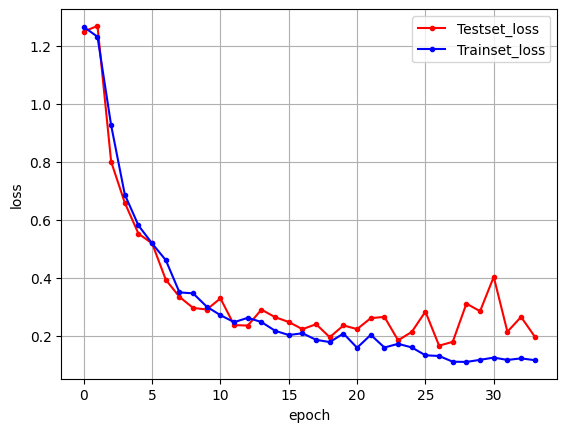

In [172]:
# 검증셋과 학습셋의 오차 저장

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='Trainset_loss')

plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [173]:
full_list = []
for path in df_full["file_path"]:
    img = plt.imread(path).astype('float32')
    img = img / 255
    img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
    full_list.append(img)

In [174]:
full_list_stack = np.stack(full_list)

In [175]:
# full_list_stack 
with tf.device('/CPU:0'):
    predict = model.predict(full_list_stack)

57/57 [==============================] - 103s 930ms/step


In [176]:
import numpy as np

# 예측값 중 가장 높은 값의 인덱스 가져오기
max_indices = np.argmax(predict, axis=1)

# 예측값을 0 또는 1로 변환
predictions = np.zeros_like(predict)
predictions[np.arange(len(predict)), max_indices] = 1

# 변환된 예측값으로 데이터프레임 생성
train_output = pd.DataFrame(predictions, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])

In [177]:
pred_y= train_output[:]
y = df_full.iloc[:,5:]

# Convert dataframes to numpy arrays
pred_y = pred_y.to_numpy().argmax(axis=1)
y = y.to_numpy().argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y, pred_y)

# Print confusion matrix

print("훈련용 데이터 오차행렬:\n",cm)

훈련용 데이터 오차행렬:
 [[508   0   1   7]
 [  6  72   9   4]
 [  0   7 615   0]
 [  8   7   0 577]]


In [178]:
print("훈련용 데이터 분류예측 리포트:\n", classification_report(y, pred_y))

훈련용 데이터 분류예측 리포트:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       516
           1       0.84      0.79      0.81        91
           2       0.98      0.99      0.99       622
           3       0.98      0.97      0.98       592

    accuracy                           0.97      1821
   macro avg       0.94      0.93      0.94      1821
weighted avg       0.97      0.97      0.97      1821



In [179]:
test_list = []
for path in df_test["file_path"]:
    img = plt.imread(path).astype('float32')
    img = img / 255
    img = cv2.resize(img, dsize=(CFG.img_size, CFG.img_size), interpolation=cv2.INTER_LINEAR)
    test_list.append(img)


In [180]:
test_list_stack = np.stack(test_list)

In [181]:
with tf.device('/CPU:0'):
    predict = model.predict(test_list_stack)

57/57 [==============================] - 53s 908ms/step


In [182]:
output = pd.DataFrame(predict)
output = output[[0, 1, 2, 3]]
lista = list(output.columns)
lista[0] = 'healthy'
lista[1] = 'multiple_diseases'
lista[2] = 'rust'
lista[3] = 'scab'
output.columns = lista
output = pd.concat([df_test[['file_name']], output], axis=1)
output = output.rename(columns={'file_name': 'image_id'})
output['image_id'] = output['image_id'].apply(lambda x: x.split('.')[0])
output.to_csv("submission2.csv", index=False)